### Nomes: Heitor de Paula Santos Damasceno e Henrique Furst Scheid

# Preâmbulo

In [17]:
from PIL import Image
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # aparentemente ajuda SVM
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
import os

# Método 1: HOG + classificador

## Implementando o HOG

In [18]:
def calculate_derivatives(image):
  x_derivative_image = np.zeros(image.shape)
  y_derivative_image = np.zeros(image.shape)
  for i in range(len(image)):
    for j in range(1, len(image[i]) - 1):
      x_derivative_image[i][j] = int(image[i][j + 1]) - int(image[i][j - 1])

  for i in range(1, len(image) - 1):
    for j in range(len(image[i])):
      y_derivative_image[i][j] = int(image[i + 1][j]) - int(image[i - 1][j])

  return (x_derivative_image, y_derivative_image)

def calculate_hist(grad_x, grad_y, size):
  tuples = []
  hist = {i: 0 for i in range(0, 9)}
  for i in range(size[1]):
    for j in range(size[0]):
      mag = np.sqrt(grad_x[i][j]**2 + grad_y[i][j]**2)
      angle = 90
      if grad_x[i][j] != 0:
        arctan = np.arctan(grad_y[i][j]/grad_x[i][j])
        if arctan < 0:
          arctan += np.pi
        angle = math.degrees(arctan)
      tuples.append((mag, angle))

  for mag, angle in tuples:
    hist_bin = angle//20
    # if hist_bin not in hist:
    #   hist[hist_bin] = 0
    hist[hist_bin] += mag
  return hist

def divide_in_cells(x_derivative_image, y_derivative_image,arr_size):
  window_size = (8, 8)

  hist_list = []
  for i in range(int(arr_size[0]/window_size[1])):
    hist_list.append([])
    for j in range(int(arr_size[1]/window_size[0])):
      xwindow_size = window_size[0]
      ywindow_size = window_size[1]
      temp_x = x_derivative_image[i*ywindow_size:(i+1)*ywindow_size, j*xwindow_size:(j+1)*xwindow_size].copy()
      temp_y = y_derivative_image[i*ywindow_size:(i+1)*ywindow_size, j*xwindow_size:(j+1)*xwindow_size].copy()
      hist = calculate_hist(temp_x, temp_y, window_size)
      hist_list[i].append(hist)
  return hist_list


In [ ]:
x_derivative_image, y_derivative_image = calculate_derivatives(image_arr)
hist_list = divide_in_cells(x_derivative_image, y_derivative_image, image_arr.shape)

In [19]:
def calculate_norm(v):
    values_sum = 0
    for i in range(len(v)):
        value = v[i]
        values_sum += value**2
    if values_sum == 0:
        return v
    return v/(np.sqrt(values_sum))

def calculate_hog(hist_matrix):
    window = (2, 2)
    hog_descriptor = []
    for i in range(len(hist_matrix) - 1):
        for j in range(len(hist_matrix[i]) - 1):
            window_v = hist_matrix[i][j] + hist_matrix[i][j + 1]\
                + hist_matrix[i + 1][j] + hist_matrix[i + 1][j + 1]
            hog_descriptor = [*hog_descriptor, *calculate_norm(window_v)]
    return hog_descriptor

## Implementando o classificador

In [20]:
def flatten_hist(hist):
    sorted_bins = sorted(hist.keys())
    return [hist[i] for i in sorted_bins]

In [21]:
def flatten_hist_matrix(hist_matrix):
    flat_hist_matrix = []
    for i in range(len(hist_matrix)):
        temp = []
        for j in range(len(hist_matrix[i])):
            flat_hist = flatten_hist(hist_matrix[i][j])
            temp.append(flat_hist)
        flat_hist_matrix.append(temp)
    return flat_hist_matrix

In [22]:
def label_index(img_name):
    img_num = img_name.split('.')[0]
    return int(img_num)

def get_six_images(dir_name, file_name):
    image = Image.open(f"dados/CAPTCHA-10k/{dir_name}/{file_name}").convert('L')
    # image = image.resize((128, 64))
    image_arr = np.array(image)
    sub_size = len(image_arr[0]) // 6
    six_image_arrs =  [image_arr[:, i*sub_size:(i+1)*sub_size] for i in range(6)]
    return [np.array(Image.fromarray(i).resize((64, 128))) for i in six_image_arrs]

def dataframe_from_flat_images(dir_name, limit=10000):
    img_files = sorted(os.listdir(f"dados/CAPTCHA-10k/{dir_name}"))
    flat_imgs = []
    it = 0
    for file in img_files:
        it += 1
        if it > limit:
            break

        six_images = get_six_images(dir_name, file)

        for image_arr in six_images:
            x_derivative_image, y_derivative_image = calculate_derivatives(image_arr)
            hist_list = divide_in_cells(x_derivative_image, y_derivative_image, image_arr.shape)
            flat_hist_matrix = flatten_hist_matrix(hist_list)
            flat_imgs.append(calculate_hog(flat_hist_matrix))

    label_files = sorted(os.listdir("dados/CAPTCHA-10k/labels10k"))
    init, end = label_index(img_files[0])-1, label_index(img_files[-1])
    labels = []
    drop_indices = []
    it = 0
    for file in label_files[init:end]:
        it += 1
        if it > limit:
            break
        with open(f"dados/CAPTCHA-10k/labels10k/{file}", "r") as f:
            label = f.read().strip()
            if len(label) > 6:
                print(f'bigger captcha: {label} in img {file}')
                drop_indices.append(it-1) # remove captchas with more than 6 chars
                continue
        for char in label:
            labels.append(char)

    for i in range(len(drop_indices)):
        if i > 0:
            i -= 6
        for j in range(6):
            flat_imgs.pop(i+j)
    return flat_imgs, labels

In [23]:
# Calcula o HOG do dataset de treino
train_x, train_y = dataframe_from_flat_images('treinamento', 5000)

In [24]:
# 15 * 7 * 36 = 3780 features cada vetor
len(train_x[0])

3780

In [25]:
# Treina o modelo
clf = svm.SVC(kernel='linear')
clf.fit(train_x, train_y)

SVC(kernel='linear')

In [26]:
# Calcula o HOG do dataset de teste
test_x, test_y = dataframe_from_flat_images('teste', 1000)

bigger captcha: WMB8YMN in img 009067.txt


## Resultados

### Acuracia

In [27]:
# Classifica o treino
pred_y = clf.predict(test_x)
accuracy_score(test_y, pred_y)

0.7337337337337337

### Exemplos

['D' 'T' 'N' 'C' 'X' 'P']


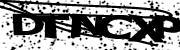

In [60]:
print(pred_y[109*6:109*6 + 6])
image = Image.open(f"dados/CAPTCHA-10k/teste/00"+str(110+9001)+".jpg").convert('L')
Image.fromarray(np.array(image), 'L')

['8' 'I' 'N' 'W' '3' 'Q']


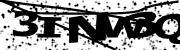

In [58]:
print(pred_y[70*6:70*6 + 6])
image = Image.open(f"dados/CAPTCHA-10k/teste/00"+str(71+9001)+".jpg").convert('L')
Image.fromarray(np.array(image), 'L')

['9' 'E' 'T' 'E' 'K' '5']


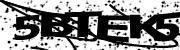

In [56]:
print(pred_y[78*6:78*6 + 6])
image = Image.open(f"dados/CAPTCHA-10k/teste/00"+str(79+9001)+".jpg").convert('L')
Image.fromarray(np.array(image), 'L')